
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load EPEACS module
from epeacs.agents.epeacs import EPEACS, Configuration

from epeacs.agents.epeacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from epeacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - EPEACS

## Common parameters

In [2]:
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Maze10-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
BETA_ALP = 0.05
BETA_RL = 0.05
EPSILON = 0.8

DO_GA = False
ENABLE_PEP = True

SLIPPERY_PROB = 0.

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ □ ■ ■ ■ ■ ■ A ■
■ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ $ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of EPEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = EPEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 29 s, sys: 249 ms, total: 29.2 s
Wall time: 32.3 s


### Performance

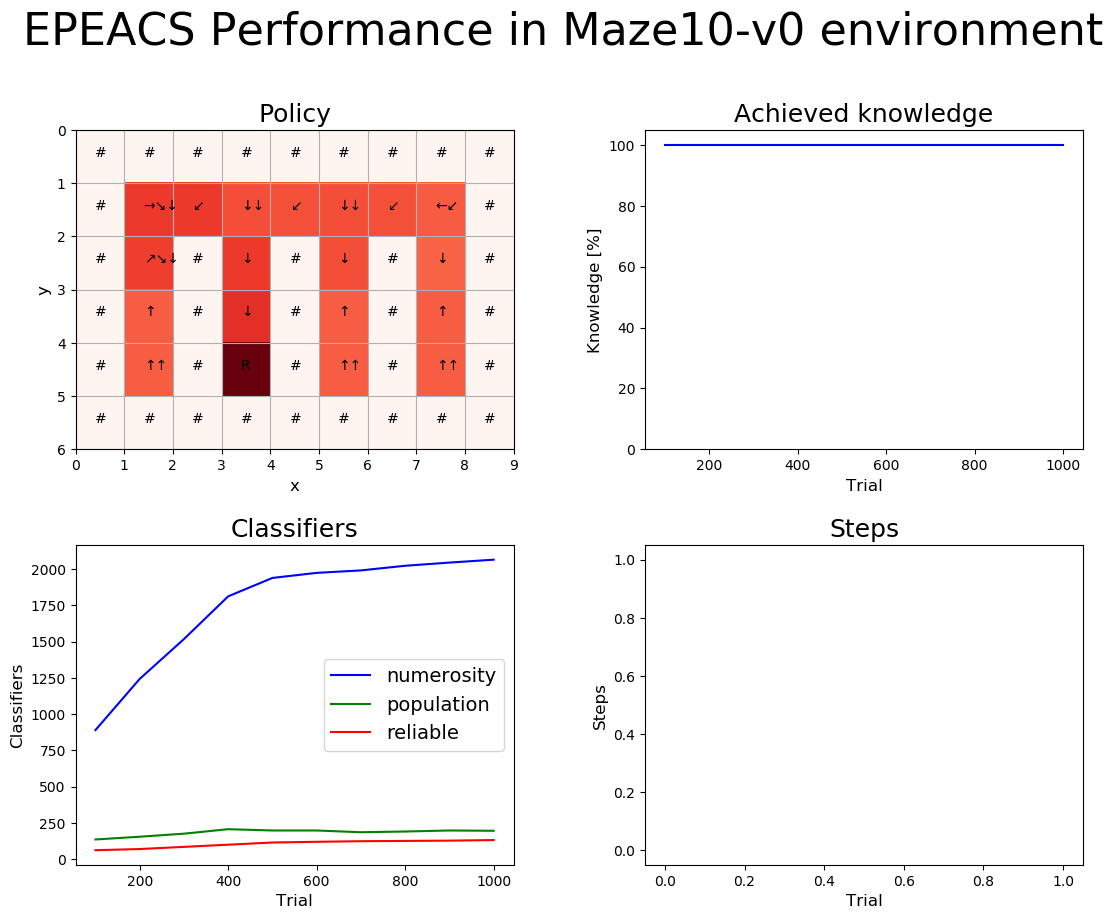

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 100.0, 'population': 195, 'numerosity': 2066, 'reliable': 131}
Full knowledge was achieved at trials  100 , was stable at  100  and the last time it was achieved at  1000
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.6879770992366412
{'trial': 1000, 'steps_in_trial': 24, 'reward': 1000, 'knowledge': 100.0, 'population': 195, 'numerosity': 2066, 'reliable': 131}
Accumulated Error on PEP Probabilities : old-> 0.1408762818415859 % new-> 0.1408762818415859 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore
    if cl.is_enhanced() or cl.behavioral_sequence]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

##01011# 2 [3, 4] (0#1#9###:#1) (11010111)
q: 0.9999 ra: 948.4  rb: 949.8  ir: 0.0    f: 948.3 
exp: 351   num: 18 ee: True PAI_state: 11001001
tga: 44409 tbseq: 3584  talp: 44409 tav: 147.1  



#1##9##1 0 [4] (########:#1) (empty)
q: 1.0    ra: 946.7  rb: 949.9  ir: 0.0    f: 948.3 
exp: 396   num: 14 ee: False PAI_state: 00110110
tga: 44718 tbseq: 1906  talp: 44718 tav: 167.1  



01##9##1 0 [4] (########:#1) (empty)
q: 1.0    ra: 945.6  rb: 950.0  ir: 0.0    f: 947.8 
exp: 396   num: 6 ee: False PAI_state: 00110110
tga: 44718 tbseq: 2720  talp: 44718 tav: 167.1  



00110111 1 [3, 4] (#1##9###:#1) (00110111)
q: 0.9936 ra: 931.1  rb: 949.6  ir: 0.0    f: 925.1 
exp: 542   num: 19 ee: True PAI_state: 11001001
tga: 44926 tbseq: 3004  talp: 44935 tav: 131.1  



01##9##1 0 [7, 5] (#0##0###:#1) (01119111)
q: 1.0    ra: 887.5  rb: 876.2  ir: 0.0    f: 876.2 
exp: 366   num: 8 ee: True PAI_state: 00110110
tga: 44921 tbseq: 4532  talp: 44921 tav: 158.5  



#1##9##1 0 [7, 5] (#0##0###:#1) 

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '1', '1', '0', '1', '1', '0'),
 ('1', '1', '0', '0', '1', '0', '0', '1'),
 ('0', '1', '1', '1', '0', '1', '1', '1')]

## Training of EPEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = EPEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 18.3 s, sys: 92.8 ms, total: 18.4 s
Wall time: 19.2 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = EPEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 7.04 s, sys: 30.6 ms, total: 7.07 s
Wall time: 7.42 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = EPEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 6.91 s, sys: 21.9 ms, total: 6.93 s
Wall time: 7.18 s


### Performance

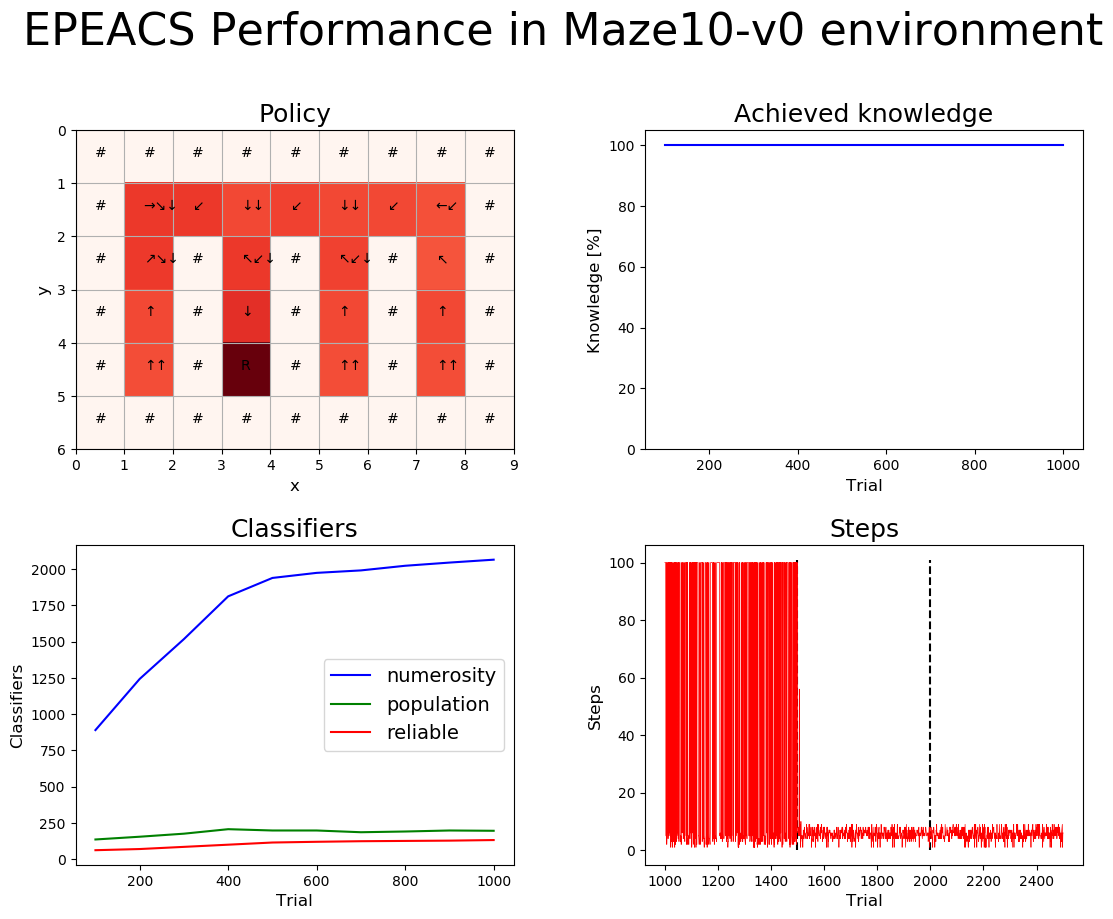

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  29.2  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  53.036  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  5.658  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  5.57  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 195, 'numerosity': 2066, 'reliable': 131}
{'knowledge': 100.0, 'population': 195, 'numerosity': 2066, 'reliable': 131}
{'knowledge': 100.0, 'population': 195, 'numerosity': 2066, 'reliable': 131}
{'knowledge': 100.0, 'population': 195, 'numerosity': 2066, 'reliable': 131}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if cl.behavioral_sequence]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")
#from epeacs.agents.epeacs import ClassifiersList
#print(len(ClassifiersList(*list(dict.fromkeys(population_exploit_rl_to_display)))))

149


##01011# 2 [3, 4] (0#1#9###:#1) (11010111)
q: 0.9999 ra: 949.7  rb: 950.0  ir: 0.0    f: 949.6 
exp: 351   num: 18 ee: True PAI_state: 11001001
tga: 44409 tbseq: 3584  talp: 44409 tav: 147.1  



#1##9##1 0 [4] (########:#1) (empty)
q: 1.0    ra: 946.7  rb: 949.9  ir: 0.0    f: 948.3 
exp: 396   num: 14 ee: False PAI_state: 00110110
tga: 44718 tbseq: 1906  talp: 44718 tav: 167.1  



01##9##1 0 [4] (########:#1) (empty)
q: 1.0    ra: 945.6  rb: 950.0  ir: 0.0    f: 947.8 
exp: 396   num: 6 ee: False PAI_state: 00110110
tga: 44718 tbseq: 2720  talp: 44718 tav: 167.1  



00110111 1 [3, 4] (#1##9###:#1) (00110111)
q: 0.9936 ra: 950.0  rb: 950.0  ir: 0.0    f: 943.9 
exp: 542   num: 19 ee: True PAI_state: 11001001
tga: 44926 tbseq: 3004  talp: 44935 tav: 131.1  



00110110 7 [5, 4] (#1##9##1:#409, #1#####1:#311) (00110110)
q: 1.0    ra: 923.9  rb: 908.3  ir: 0.0    f: 908.3 
exp: 724   num: 14 ee: True PAI_state: 11001001
tga: 44833 tbseq: 3695  talp: 44930 tav: 53.07  



11010#01